# Load packages

In [17]:
from metaspace import SMInstance
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.special import binom
import seaborn as sns
import os

import torch
import torch.nn.functional as functional
from ionimage_embedding.models import CLR
from ionimage_embedding.models.clr.pseudo_labeling import compute_dataset_ublb, pseudo_labeling
from ionimage_embedding.models.clr.utils import size_adaption, size_adaption_symmetric

import umap
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helper functions

In [18]:
def same_ion_similarity(model, ax, new_data=None, new_ion_labels_int=None):

    # Inference of embeddings
    embeddings = model.predict_embeddings(new_data=new_data)
    embeddings = functional.normalize(torch.tensor(embeddings), p=2, dim=-1)
    embeddings = embeddings / embeddings.norm(dim=1)[:, None]
    embeddings = embeddings.cpu().detach().numpy()

    # Compute distance between same ions
    if new_data is not None:
        ill_int = new_ion_labels_int
    else:
        ill_int = model.ill_int
    
    same_similarities = []
    same_ion_counter = 0
    for i in set(ill_int):
        if len(embeddings[ill_int==i]) > 1:
            a = pairwise_kernels(embeddings[ill_int==i], metric='cosine')
            np.fill_diagonal(a, val=0)
            same_similarities.append(a.sum()/(binom(a.shape[0], 2)*2))
            same_ion_counter += 1
            
    print(f'{same_ion_counter} ions observed in multiple images')
    # Compute distance between all Sample N random similarities that are not the same ion
    different_similarities = []
    for i in range(5000):
        if new_data is None:
            samples = np.random.randint(0, high=model.image_data.shape[0], size=2)
        else:
            samples = np.random.randint(0, high=new_data.shape[0], size=2)
        if ill_int[samples[0]] != ill_int[samples[1]]:
            a = pairwise_kernels(embeddings[samples], metric='cosine')
            different_similarities.append(a[1,0])

    # Plot distances as violins
    final_df = pd.concat([pd.DataFrame({'type': 'Same ion', 'similarity': same_similarities}), 
                          pd.DataFrame({'type': 'Different ion', 'similarity': different_similarities})])
    sns.violinplot(final_df, x='type', y='similarity', ax=ax)
    ax.set_title('Ion similarity')


def compute_centroids(embeddings, ion_labels):
    
    ion_centroids = []
    centroid_labels = []
    for i in set(ion_labels):
        if len(embeddings[ion_labels==i]) > 1:
            a = embeddings[ion_labels==i]
            ion_centroids.append(a.sum(axis=0)/a.shape[0])
            centroid_labels.append(i)
        else:
            ion_centroids.append(embeddings[ion_labels==i][0])
            centroid_labels.append(i)
            
    return np.stack(ion_centroids), centroid_labels
    
def adduct_similarity(model, ax, separator='+', new_data=None, new_ion_labels=None):
    
    embeddings = model.predict_embeddings(new_data=new_data)
    embeddings = functional.normalize(torch.tensor(embeddings), p=2, dim=-1)
    embeddings = embeddings / embeddings.norm(dim=1)[:, None]
    embeddings = embeddings.cpu().detach().numpy()
    
    if new_data is not None:
        ill = new_ion_labels
    else:
        ill= model.ion_labels
    
    # Todo: there This will also count same ions from different datasets
    
    ion_centroids, centroid_labels = compute_centroids(embeddings, ill)    
    molecules = np.array([x.split(separator)[0] for x in centroid_labels])
    
    same_similarities = []
    same_molecule_counter = 0
    for mol in set(molecules):
        # Only if there exists multiple adducts
        if sum(molecules==mol) > 1:
            # Compute mean similarity between adducts
            a = pairwise_kernels(ion_centroids[molecules==mol], metric='cosine')
            np.fill_diagonal(a, val=0)
            same_similarities.append(a.sum()/(binom(a.shape[0], 2)*2))
            same_molecule_counter +=1
            
    print(f'{same_molecule_counter} molecules observed in multiple images')
    
    # Sample different ions
    different_similarities = []
    for i in range(5000):
        samples = np.random.randint(0, high=ion_centroids.shape[0], size=2)
        if molecules[samples[0]] != molecules[samples[1]]:
            a = pairwise_kernels(embeddings[samples], metric='cosine')
            different_similarities.append(a[1,0])
    
    final_df = pd.concat([pd.DataFrame({'type': 'Same molecule', 'similarity': same_similarities}), 
                          pd.DataFrame({'type': 'Different molecule', 'similarity': different_similarities})])
    sns.violinplot(final_df, x='type', y='similarity', ax=ax)
    ax.set_title('Molecule similarity')
    

# Datasets

In [19]:
evaluation_datasets = [
    '2022-12-07_02h13m50s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s',
    '2022-12-07_01h01m06s',
    '2022-11-28_22h24m25s',
    '2022-11-28_22h23m30s'
                  ]

In [20]:
training_results = {}
training_images = {}
training_if = {}
polarity = '+'

sm = SMInstance()

for k in evaluation_datasets:
    ds = sm.dataset(id=k)
    results = ds.results(database=("HMDB", "v4"), fdr=0.2).reset_index()
    training_results[k] = results
    tmp = ds.all_annotation_images(fdr=0.2, database=("HMDB", "v4"), only_first_isotope=True)
    onsample = dict(zip(results['formula'].str.cat(results['adduct']), ~results['offSample']))
    formula = [x.formula+x.adduct for x in tmp if onsample[x.formula+x.adduct]]
    tmp = np.array([x._images[0] for x in tmp if onsample[x.formula+x.adduct]])
    training_images[k] = tmp
    training_if[k] = formula

100%|████████████████████████████████████████| 220/220 [00:01<00:00, 212.13it/s]


# Data preprocessing

In [21]:
[x.shape for x in training_images.values()]

[(245, 74, 84),
 (221, 88, 88),
 (194, 41, 78),
 (237, 56, 85),
 (276, 71, 82),
 (201, 35, 55),
 (186, 60, 44),
 (189, 92, 79),
 (182, 85, 91)]

In [22]:
padding_images = size_adaption_symmetric(training_images)
[x.shape for x in padding_images.values()]

[(245, 92, 92),
 (221, 92, 92),
 (194, 92, 92),
 (237, 92, 92),
 (276, 92, 92),
 (201, 92, 92),
 (186, 92, 92),
 (189, 92, 92),
 (182, 92, 92)]

In [23]:
tst = set(training_if['2022-12-07_02h13m50s']).intersection(set(training_if['2022-12-07_02h13m20s']), 
                                                          set(training_if['2022-12-07_02h10m45s']), 
                                                          set(training_if['2022-12-07_02h09m41s']), 
                                                          set(training_if['2022-12-07_02h08m52s']), 
                                                          set(training_if['2022-12-07_01h02m53s']), 
                                                          set(training_if['2022-12-07_01h01m06s']))

In [24]:
print(f'Intersection of all datasets: {len(tst)}')

Intersection of all datasets: 126


# Preparing data

In [25]:
training_dsid = [
    '2022-12-07_01h01m06s',
    '2022-12-07_02h13m20s',
    '2022-12-07_02h10m45s',
    '2022-12-07_02h09m41s',
    '2022-12-07_02h08m52s',
    '2022-12-07_01h02m53s',
    '2022-12-07_02h13m50s'
                  ]

testing_dsid = [
    '2022-11-28_22h24m25s',
    '2022-11-28_22h23m30s'
]

In [26]:
training_data = []
training_datasets = [] 
training_ions = []

testing_data = []
testing_datasets = [] 
testing_ions = []


for dsid, imgs in padding_images.items():
    
    if dsid in training_dsid:
        training_data.append(imgs)
        training_datasets += [dsid] * imgs.shape[0]
        training_ions += training_if[dsid]
    else:
        testing_data.append(imgs)
        testing_datasets += [dsid] * imgs.shape[0]
        testing_ions += training_if[dsid]
        
    
training_data = np.concatenate(training_data)
training_datasets = np.array(training_datasets)
training_ions = np.array(training_ions)

testing_data = np.concatenate(testing_data)
testing_datasets = np.array(testing_datasets)
testing_ions = np.array(testing_ions)

# Activation comparison

## Softmax

In [29]:
model_softmax = CLR(
                    images=training_data,
                    dataset_labels=training_datasets,
                    ion_labels=training_ions,
                    num_cluster=8,
                    initial_upper=93,
                    initial_lower=37,
                    upper_iteration=1.5,
                    lower_iteration=1.5,
                    dataset_specific_percentiles=True,
                    random_flip=True,
                    knn=True, k=5,
                    lr=0.001, batch_size=128,
                    pretraining_epochs=11,
                    training_epochs=16,
                    cae_encoder_dim=20,
                    use_gpu=True,
                    activation='softmax',
                    overweight_cae=0.5,
                    cnn_dropout=.2,
                    random_seed=np.random.randint(0, 10000)
                   )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [30]:
model_softmax.train()

CAE Final conv size = 3600
CNNClust final conv dim = 324
Pretraining Epoch: 00 Training Loss: 0.031766 | Validation Loss: 0.024727
Pretraining Epoch: 01 Training Loss: 0.015959 | Validation Loss: 0.023776
Pretraining Epoch: 02 Training Loss: 0.011750 | Validation Loss: 0.021964
Pretraining Epoch: 03 Training Loss: 0.009403 | Validation Loss: 0.020959
Pretraining Epoch: 04 Training Loss: 0.008374 | Validation Loss: 0.018608
Pretraining Epoch: 05 Training Loss: 0.007984 | Validation Loss: 0.017353
Pretraining Epoch: 06 Training Loss: 0.007701 | Validation Loss: 0.016556
Pretraining Epoch: 07 Training Loss: 0.007466 | Validation Loss: 0.016281
Pretraining Epoch: 08 Training Loss: 0.007376 | Validation Loss: 0.014911
Pretraining Epoch: 09 Training Loss: 0.007328 | Validation Loss: 0.012700
Pretraining Epoch: 10 Training Loss: 0.007165 | Validation Loss: 0.012677
Epoch: 00 | CAE-Loss: 0.039472 | CNN-Loss: 0.369427 | Total loss: 0.389163
  * Val:  | CAE-Loss: 0.101289 | CNN-Loss: 6.605723
Ep

0

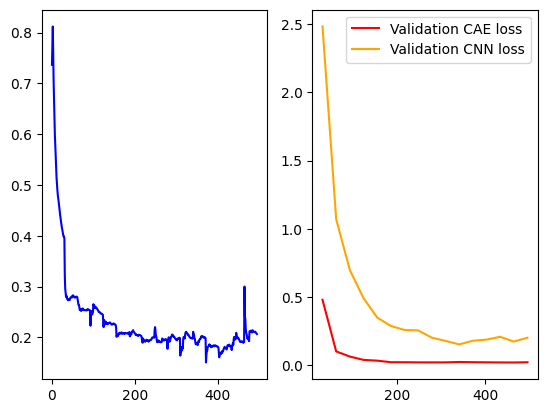

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(model_softmax.loss_list, '-', label='Combined training loss', color='blue')
ax2.plot((np.arange(model_softmax.training_epochs)+1)*31, model_softmax.val_losses_cae, '-', label='Validation CAE loss', color='red')
ax2.plot((np.arange(model_softmax.training_epochs)+1)*31, model_softmax.val_losses_clust, '-', label='Validation CNN loss', color='orange')
plt.legend()
plt.show()

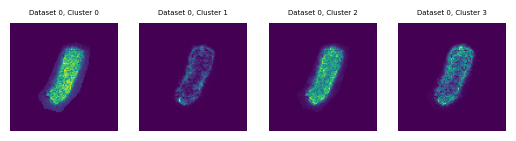

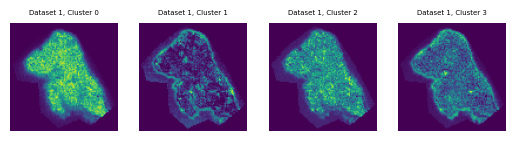

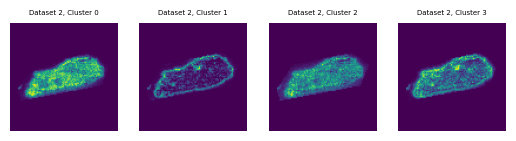

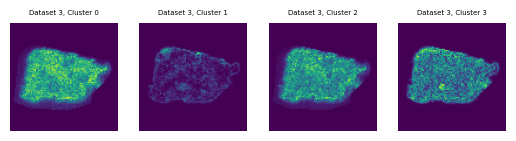

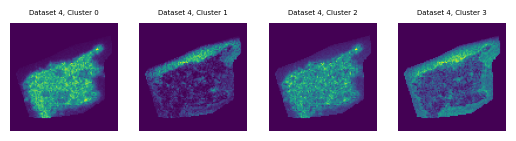

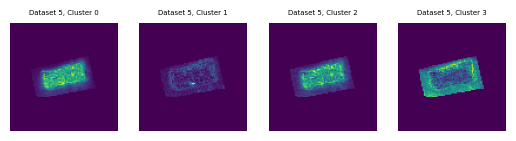

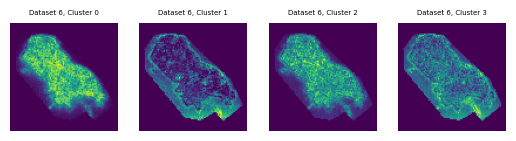

In [27]:
pred_labels1 = model_softmax.inference()

# Loop over datasets:
ds_counter = 0
for ds in training_dsid:
    
    ds_imgs = model_softmax.image_data[model_softmax.dataset_labels==ds]
    curr_labels = pred_labels1[model_softmax.dataset_labels==ds]
    
    cluster_ion_images = []
    for cluster in set(pred_labels1):
        tmp = np.mean(ds_imgs[curr_labels==cluster], axis=0)
        cluster_ion_images.append(tmp)
    fig, axs = plt.subplots(ncols=len(set(pred_labels1)))
    counter = 0
    for ax, im in zip(axs, cluster_ion_images):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f'Dataset {ds_counter}, Cluster {counter}', fontdict={'fontsize': 5})
        counter += 1
    plt.show()
    ds_counter += 1


### Evaluation

289 ions observed in multiple images
69 molecules observed in multiple images


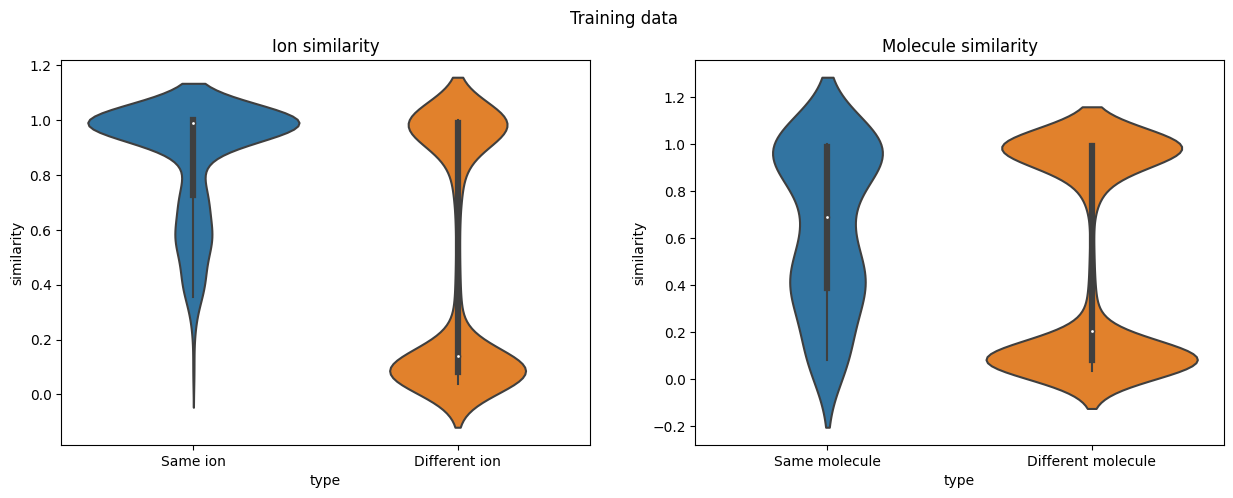

In [48]:
model = model_softmax

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.suptitle('Training data')
same_ion_similarity(model, ax1)
adduct_similarity(model, ax2)
plt.show()

150 ions observed in multiple images
58 molecules observed in multiple images


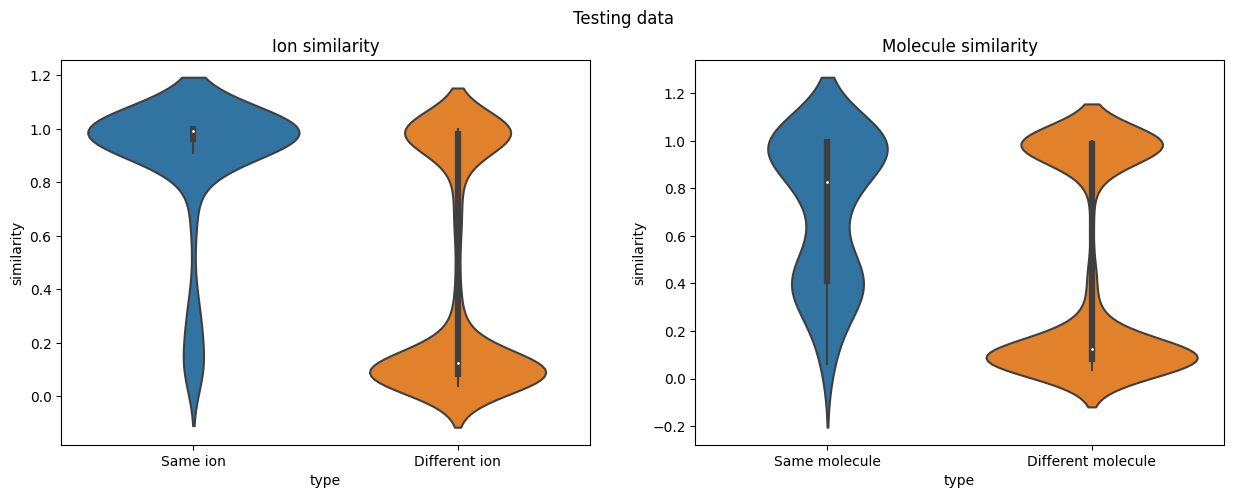

In [49]:
model = model_softmax

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.suptitle('Testing data')
ion_encoder = preprocessing.LabelEncoder()
testing_ion_int = ion_encoder.fit_transform(testing_ions)

same_ion_similarity(model, ax1, new_data=testing_data, new_ion_labels_int=testing_ion_int)
adduct_similarity(model, ax2, new_data=testing_data, new_ion_labels=testing_ions)
plt.show()

### Embeddings

[Text(0.5, 1.0, 'Training data')]

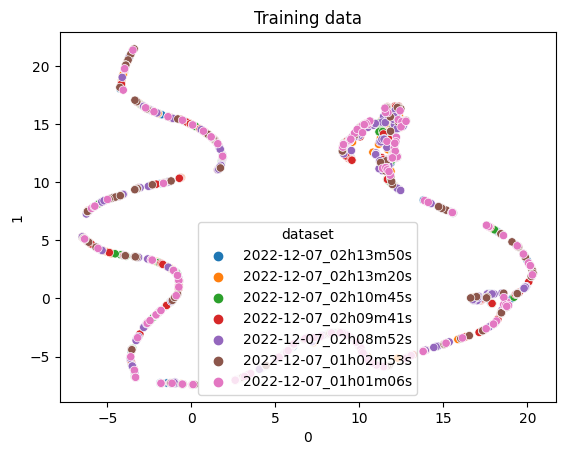

In [39]:
model = model_softmax

reducer = umap.UMAP()
embeddings = model.predict_embeddings()
embeddings = functional.normalize(torch.tensor(embeddings), p=2, dim=-1)
embeddings = embeddings / embeddings.norm(dim=1)[:, None]
embeddings = embeddings.cpu().detach().numpy()

data = pd.DataFrame(reducer.fit_transform(embeddings))
data['dataset'] = model.dataset_labels

sns.scatterplot(data, x=0, y=1, hue='dataset').set(title='Training data')

[Text(0.5, 1.0, 'Training data')]

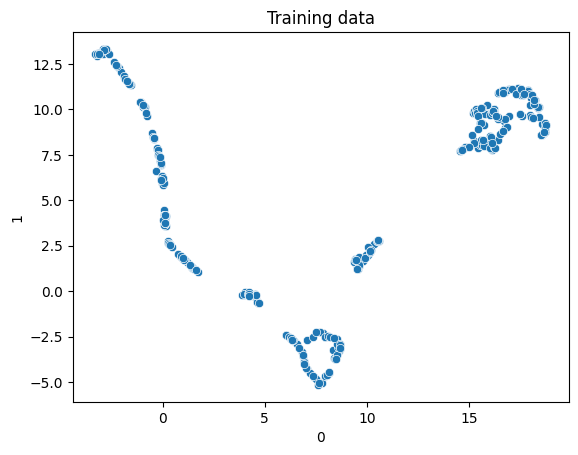

In [51]:
# Centroids embeddings
model = model_softmax

reducer = umap.UMAP()
embeddings = model.predict_embeddings()
embeddings = functional.normalize(torch.tensor(embeddings), p=2, dim=-1)
embeddings = embeddings / embeddings.norm(dim=1)[:, None]
embeddings = embeddings.cpu().detach().numpy()

centroids, centroid_labels = compute_centroids(embeddings, model.ion_labels)

data = pd.DataFrame(reducer.fit_transform(centroids))

sns.scatterplot(data, x=0, y=1).set(title='Training data')

[Text(0.5, 1.0, 'Testing data')]

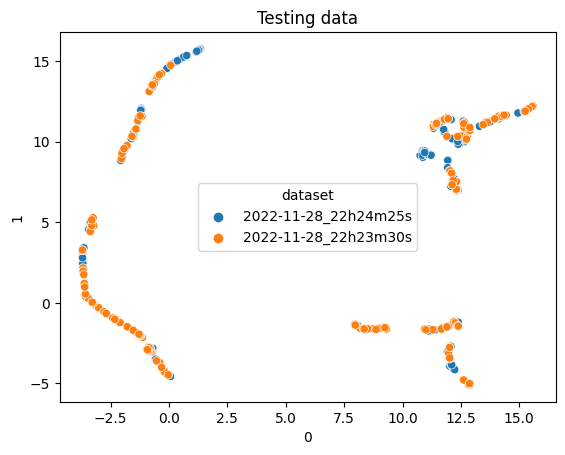

In [40]:
model = model_softmax

reducer = umap.UMAP()
embeddings = model.predict_embeddings(new_data=testing_data)
embeddings = functional.normalize(torch.tensor(embeddings), p=2, dim=-1)
embeddings = embeddings / embeddings.norm(dim=1)[:, None]
embeddings = embeddings.cpu().detach().numpy()

data = pd.DataFrame(reducer.fit_transform(embeddings))
data['dataset'] = testing_datasets

sns.scatterplot(data, x=0, y=1, hue='dataset').set(title='Testing data')

## ReLU

In [74]:
# Relu is a real bitch. Super easy to get too high gradients resulting in nans
model_relu = CLR(
                 images=training_data,
                 dataset_labels=training_datasets,
                 ion_labels=training_ions,
                 num_cluster=8,
                 initial_upper=93,
                 initial_lower=37,
                 upper_iteration=1.5,
                 lower_iteration=1.5,
                 dataset_specific_percentiles=True,
                 random_flip=True,
                 knn=True, k=5,
                 lr=0.0001, batch_size=60,
                 pretraining_epochs=11,
                 training_epochs=16,
                 cae_encoder_dim=20,
                 use_gpu=True,
                 activation='relu',
                 overweight_cae=0.5,
                 clip_gradients=.05,
                 weight_decay=1e-2,
                 cnn_dropout=.2,
                 random_seed=np.random.randint(0, 10000)
                )

After 16 epochs, the upper bound will be: 69.0.
After 16 epochs, the lower bound will be: 61.0.


In [75]:
model_relu.train()

CAE Final conv size = 3600
CNNClust final conv dim = 324
Pretraining Epoch: 00 Training Loss: 0.121282 | Validation Loss: 0.020403
Pretraining Epoch: 01 Training Loss: 0.019098 | Validation Loss: 0.016490
Pretraining Epoch: 02 Training Loss: 0.013891 | Validation Loss: 0.015301
Pretraining Epoch: 03 Training Loss: 0.010096 | Validation Loss: 0.011200
Pretraining Epoch: 04 Training Loss: 0.008572 | Validation Loss: 0.009475
Pretraining Epoch: 05 Training Loss: 0.007911 | Validation Loss: 0.008415
Pretraining Epoch: 06 Training Loss: 0.007486 | Validation Loss: 0.008106
Pretraining Epoch: 07 Training Loss: 0.007308 | Validation Loss: 0.008244
Pretraining Epoch: 08 Training Loss: 0.007124 | Validation Loss: 0.008591
Pretraining Epoch: 09 Training Loss: 0.007053 | Validation Loss: 0.007583
Pretraining Epoch: 10 Training Loss: 0.006940 | Validation Loss: 0.008114
Epoch: 00 | CAE-Loss: nan | CNN-Loss: nan | Total loss: nan
  * Val:  | CAE-Loss: nan | CNN-Loss: nan
Epoch: 01 | CAE-Loss: nan |

0

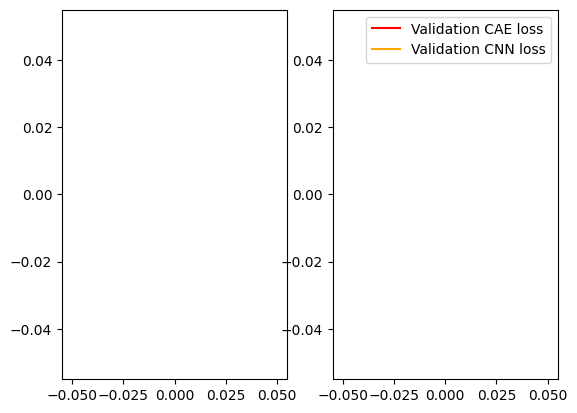

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(model_relu.loss_list, '-', label='Combined training loss', color='blue')
ax2.plot((np.arange(model_relu.training_epochs)+1)*31, model_relu.val_losses_cae, '-', label='Validation CAE loss', color='red')
ax2.plot((np.arange(model_relu.training_epochs)+1)*31, model_relu.val_losses_clust, '-', label='Validation CNN loss', color='orange')
plt.legend()
plt.show()

## Sigmoid

In [16]:
model_sigmoid = CLR(
                    images=training_data,
                    dataset_labels=training_datasets,
                    ion_labels=training_ions,
                    num_cluster=8,
                    initial_upper=93,
                    initial_lower=37,
                    upper_iteration=1.5,
                    lower_iteration=1.5,
                    dataset_specific_percentiles=True,
                    random_flip=True,
                    knn=True, k=5,
                    lr=0.0001, batch_size=128,
                    pretraining_epochs=11,
                    training_epochs=7,
                    cae_encoder_dim=20,
                    use_gpu=True,
                    activation='sigmoid',
                    overweight_cae=0.5,
                    clip_gradients=None,
                    weight_decay=1e-3,
                    cnn_dropout=.2,
                    random_seed=np.random.randint(0, 10000)
                   )

After 7 epochs, the upper bound will be: 82.5.
After 7 epochs, the lower bound will be: 47.5.


In [17]:
model_sigmoid.train()

CAE Final conv size = 3600
CNNClust final conv dim = 324
Pretraining Epoch: 00 Training Loss: 0.083959 | Validation Loss: 0.024754
Pretraining Epoch: 01 Training Loss: 0.022815 | Validation Loss: 0.019381
Pretraining Epoch: 02 Training Loss: 0.017895 | Validation Loss: 0.019317
Pretraining Epoch: 03 Training Loss: 0.012419 | Validation Loss: 0.013412
Pretraining Epoch: 04 Training Loss: 0.008685 | Validation Loss: 0.009405
Pretraining Epoch: 05 Training Loss: 0.007648 | Validation Loss: 0.007791
Pretraining Epoch: 06 Training Loss: 0.007203 | Validation Loss: 0.008209
Pretraining Epoch: 07 Training Loss: 0.006976 | Validation Loss: 0.006954
Pretraining Epoch: 08 Training Loss: 0.006751 | Validation Loss: 0.006743
Pretraining Epoch: 09 Training Loss: 0.006670 | Validation Loss: 0.006721
Pretraining Epoch: 10 Training Loss: 0.006626 | Validation Loss: 0.007265
Epoch: 00 | CAE-Loss: 0.032140 | CNN-Loss: 1.286378 | Total loss: 1.302448
  * Val:  | CAE-Loss: 0.095304 | CNN-Loss: 8.513700
Ep

0

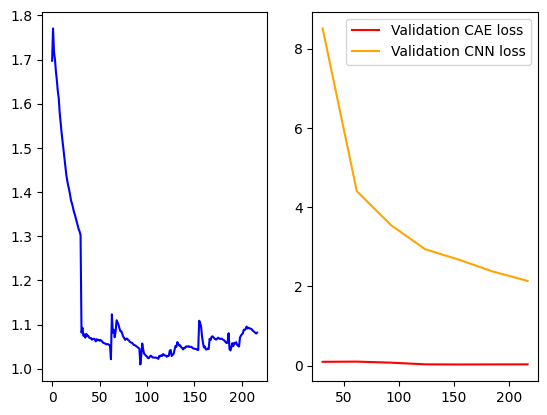

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(model_sigmoid.loss_list, '-', label='Combined training loss', color='blue')
ax2.plot((np.arange(model_sigmoid.training_epochs)+1)*31, model_sigmoid.val_losses_cae, '-', label='Validation CAE loss', color='red')
ax2.plot((np.arange(model_sigmoid.training_epochs)+1)*31, model_sigmoid.val_losses_clust, '-', label='Validation CNN loss', color='orange')
plt.legend()
plt.show()

### Evaluation

289 ions observed in multiple images
69 molecules observed in multiple images


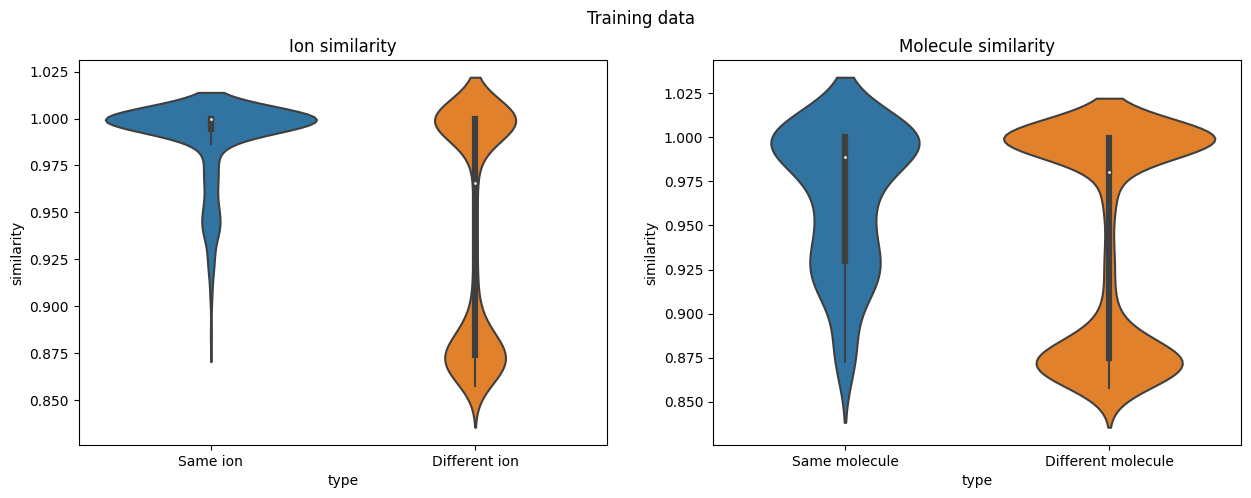

In [41]:
model = model_sigmoid

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.suptitle('Training data')
same_ion_similarity(model, ax1)
adduct_similarity(model, ax2)
plt.show()

150 ions observed in multiple images
58 molecules observed in multiple images


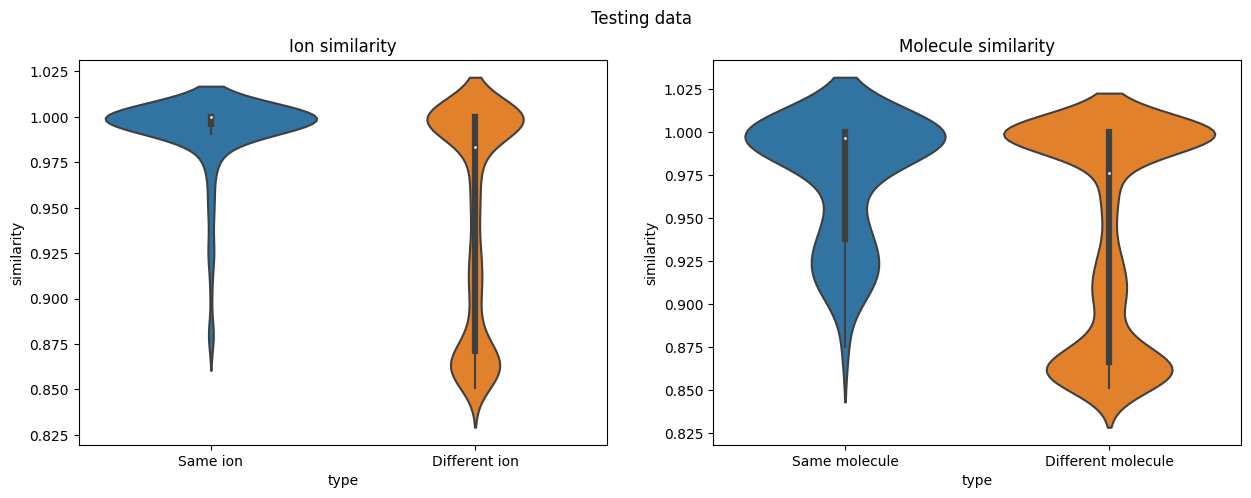

In [42]:
model = model_sigmoid

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.suptitle('Testing data')
ion_encoder = preprocessing.LabelEncoder()
testing_ion_int = ion_encoder.fit_transform(testing_ions)

same_ion_similarity(model, ax1, new_data=testing_data, new_ion_labels_int=testing_ion_int)
adduct_similarity(model, ax2, new_data=testing_data, new_ion_labels=testing_ions)
plt.show()

### Embeddings

[Text(0.5, 1.0, 'Training data')]

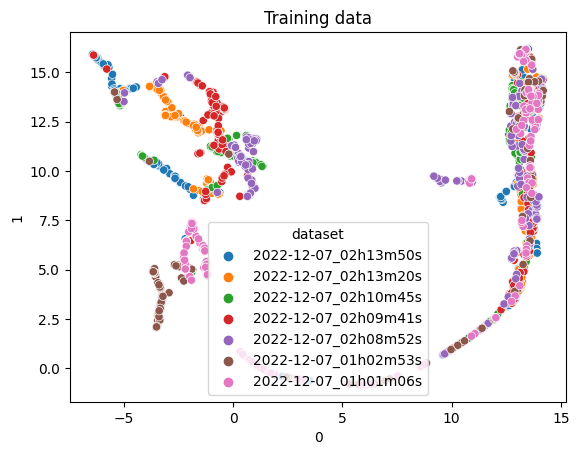

In [43]:
model = model_sigmoid

reducer = umap.UMAP()
embeddings = model.predict_embeddings()
embeddings = functional.normalize(torch.tensor(embeddings), p=2, dim=-1)
embeddings = embeddings / embeddings.norm(dim=1)[:, None]
embeddings = embeddings.cpu().detach().numpy()

data = pd.DataFrame(reducer.fit_transform(embeddings))
data['dataset'] = model.dataset_labels

sns.scatterplot(data, x=0, y=1, hue='dataset').set(title='Training data')

[Text(0.5, 1.0, 'Testing data')]

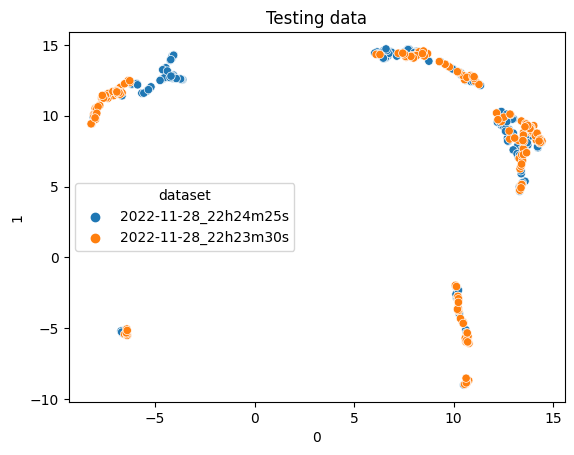

In [44]:
model = model_sigmoid

reducer = umap.UMAP()
embeddings = model.predict_embeddings(new_data=testing_data)
embeddings = functional.normalize(torch.tensor(embeddings), p=2, dim=-1)
embeddings = embeddings / embeddings.norm(dim=1)[:, None]
embeddings = embeddings.cpu().detach().numpy()

data = pd.DataFrame(reducer.fit_transform(embeddings))
data['dataset'] = testing_datasets

sns.scatterplot(data, x=0, y=1, hue='dataset').set(title='Testing data')